In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [ ]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [ ]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

In [ ]:
stations_point = gpd.read_file('./clean_data/stations_point.geojson')
stations_area = gpd.read_file('./clean_data/stations_area.geojson')

# Import traffic collisions

In [ ]:
# geojson format is too big -> use csv instead
collision_point = pd.read_csv('./clean_data/collision_point.csv')
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

C:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [ ]:
collision_point

,X,Y,ObjectId,event_unique_id,occurrencedate,occurrencemonth,occurrencedayofweek,occurrenceyear,occurrencehour,Division,Neighbourhood,Fatalities,Injury_Collisions,FTR_Collisions,PD_Collisions,Long,Lat,ObjectId2,Hood_ID,occurrenceday,occurrencedayofyear,geometry,Fatal_Collisions
0,0.000000e+00,0.000000e+00,278,GO-20141591056,2014-02-24 17:00:00-04:00,February,Monday,2014,17,D32,St.Andrew-Windfields,0,0,1,0,-79.402034,43.748097,178,40,24.0,55.0,POINT (-79.40203 43.74810),0
1,0.000000e+00,0.000000e+00,1246,GO-20143120578,2014-10-17 09:00:00-04:00,October,Friday,2014,9,D31,Glenfield-Jane Heights,0,0,0,1,-79.513544,43.743014,1046,25,17.0,290.0,POINT (-79.51354 43.74301),0
2,0.000000e+00,0.000000e+00,21564,GO-20168056919,2016-12-17 09:00:00-04:00,December,Saturday,2016,9,D31,York University Heights,0,0,0,1,-79.498253,43.763907,21094,27,17.0,352.0,POINT (-79.49825 43.76391),0
3,0.000000e+00,0.000000e+00,21709,GO-20168059092,2016-12-27 18:00:00-04:00,December,Tuesday,2016,18,D32,Yorkdale-Glen Park,0,0,1,0,-79.459962,43.707040,21162,31,27.0,362.0,POINT (-79.45996 43.70704),0
4,0.000000e+00,0.000000e+00,21277,GO-20168053844,2016-11-30 18:00:00-04:00,November,Wednesday,2016,18,D33,Hillcrest Village,0,0,0,1,-79.352088,43.807805,21340,48,30.0,335.0,POINT (-79.35209 43.80780),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430281,-8.865398e+06,5.426816e+06,499212,GO-20178006796,2017-02-14 14:00:00-04:00,February,Tuesday,2017,14,NSA,NSA,0,0,0,1,-79.639225,43.749873,499534,NSA,14.0,45.0,POINT (-79.63923 43.74987),0
430282,-8.865398e+06,5.426816e+06,499213,GO-20178007507,2017-02-18 13:00:00-04:00,February,Saturday,2017,13,NSA,NSA,0,0,1,0,-79.639225,43.749873,499535,NSA,18.0,49.0,POINT (-79.63923 43.74987),0
430283,-8.865398e+06,5.426816e+06,499214,GO-20178008123,2017-02-22 22:00:00-04:00,February,Wednesday,2017,22,D23,West Humber-Clairville,0,0,0,1,-79.639225,43.749873,499536,1,22.0,53.0,POINT (-79.63923 43.74987),0
430284,-8.865398e+06,5.426816e+06,499215,GO-20178014940,2017-04-07 14:00:00-04:00,April,Friday,2017,14,NSA,NSA,0,0,0,1,-79.639225,43.749873,499537,NSA,7.0,97.0,POINT (-79.63923 43.74987),0


In [ ]:
collision_point.columns

Index(['X', 'Y', 'ObjectId', 'event_unique_id', 'occurrencedate',
       'occurrencemonth', 'occurrencedayofweek', 'occurrenceyear',
       'occurrencehour', 'Division', 'Neighbourhood', 'Fatalities',
       'Injury_Collisions', 'FTR_Collisions', 'PD_Collisions', 'Long', 'Lat',
       'ObjectId2', 'Hood_ID', 'occurrenceday', 'occurrencedayofyear',
       'geometry', 'Fatal_Collisions'],
      dtype='object')

In [ ]:
collision_point.replace({'occurrencemonth': {'January': 'Jan', 
                                             'February': 'Feb', 
                                             'March': 'Mar', 
                                             'April': 'Apr', 
                                             'May': 'May', 
                                             'June': 'Jun', 
                                             'July': 'Jul', 
                                             'August': 'Aug', 
                                             'September': 'Sep', 
                                             'October': 'Oct', 
                                             'November': 'Nov', 
                                             'December': 'Dec'},
                         'occurrencedayofweek': {'Monday': "Mon", 
                                                 'Tuesday': "Tue", 
                                                 'Wednesday': "Wed", 
                                                 'Thursday': "Thu", 
                                                 'Friday': "Fri", 
                                                 'Saturday': "Sat", 
                                                 'Sunday': "Sun"}}, inplace=True)

Text(0.5, 0.98, 'Number of traffic collisions by time period in Toronto neighbourhoods')

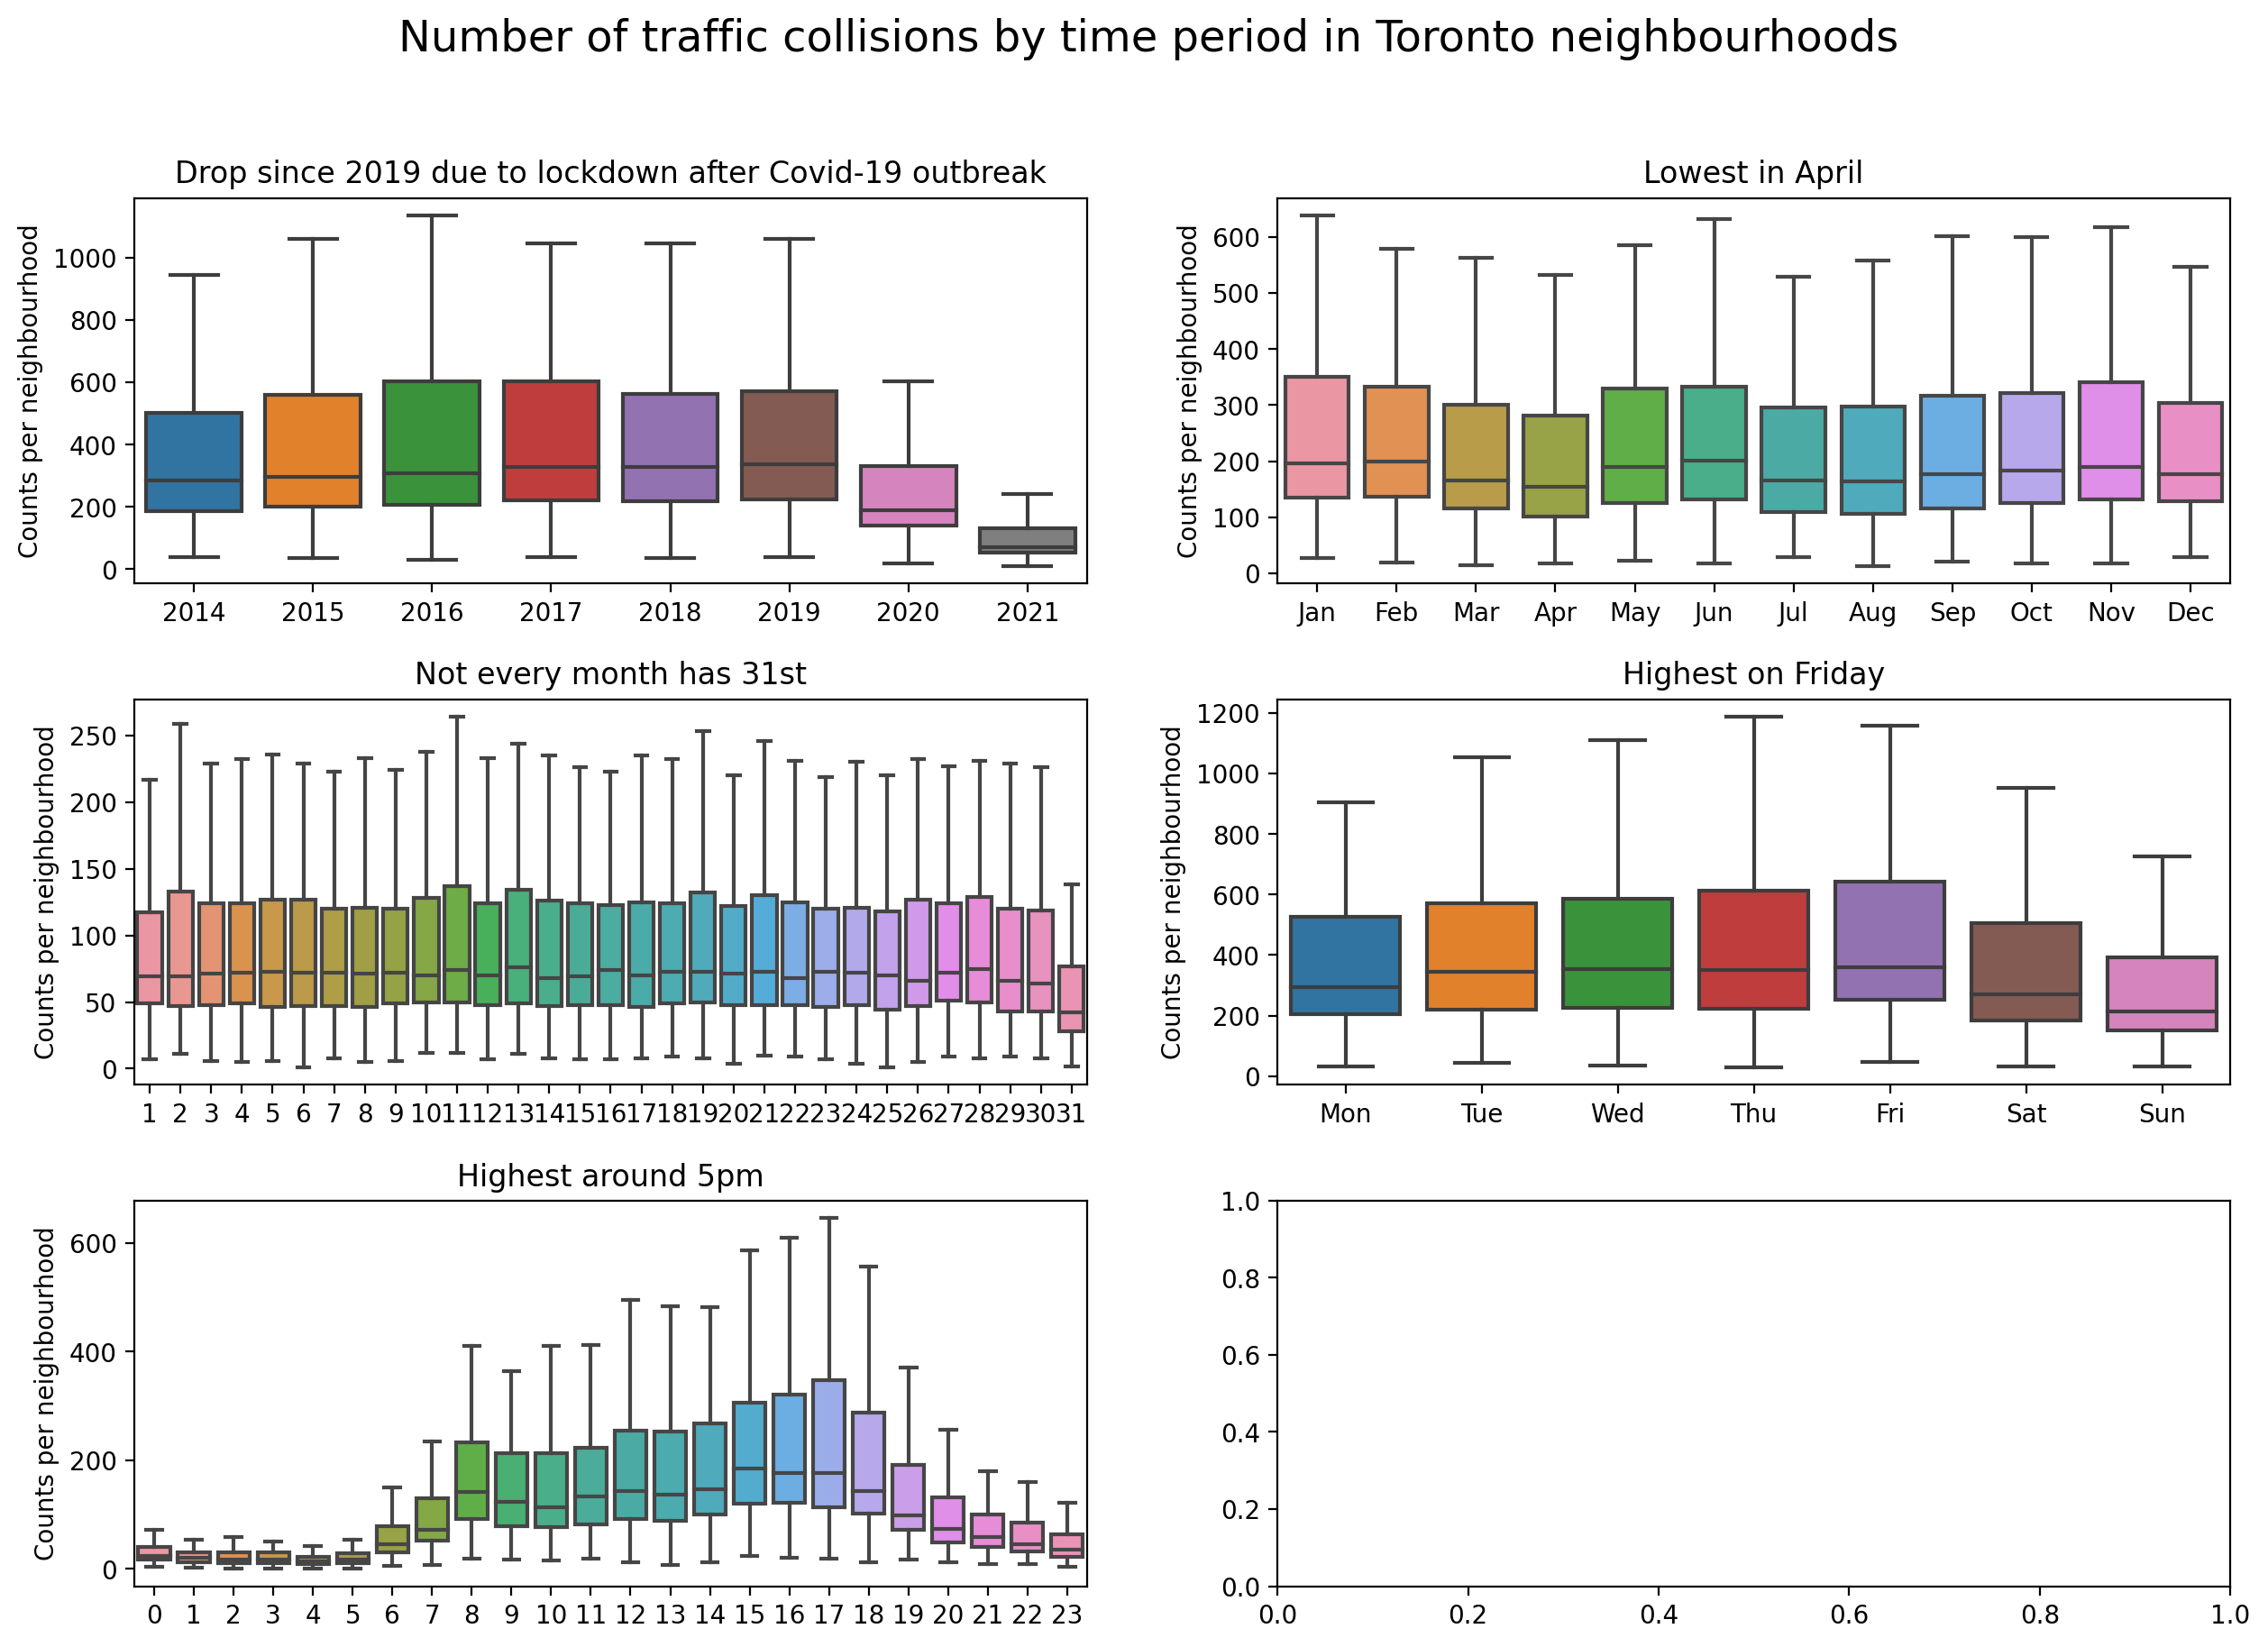

In [ ]:
vars = ['occurrenceyear', 
        'occurrencemonth', 
        'occurrenceday',
        'occurrencedayofweek',
        'occurrencehour']
vars_cat = [[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            np.arange(1,32,1),
            ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            np.arange(0,24,1)
            ]
titles = ['Drop since 2019 due to lockdown after Covid-19 outbreak',
         'Lowest in April',
         'Not every month has 31st',
         'Highest on Friday',
         'Highest around 5pm']

fig, axes = plt.subplots(int(math.ceil(len(vars)/2)),2)
plt.subplots_adjust(hspace=0.3)
for var, var_cat, title, ax in zip(vars, vars_cat, titles, axes.flatten()):    
    collision_point[var] = collision_point[var].astype('category').cat.set_categories(var_cat)
    sns.boxplot(data = collision_point.groupby(['Neighbourhood', var]).size().reset_index(name='count'), 
                x = var,
                y = 'count',
                showfliers = False,
                ax = ax)
    ax.set_ylabel('Counts per neighbourhood')
    ax.set_xlabel('')
    ax.set_title(title)

fig.suptitle('Number of traffic collisions by time period in Toronto neighbourhoods', size='xx-large')

Text(0.5, 0.98, 'Traffic collisions in Toronto neighbourhoods')

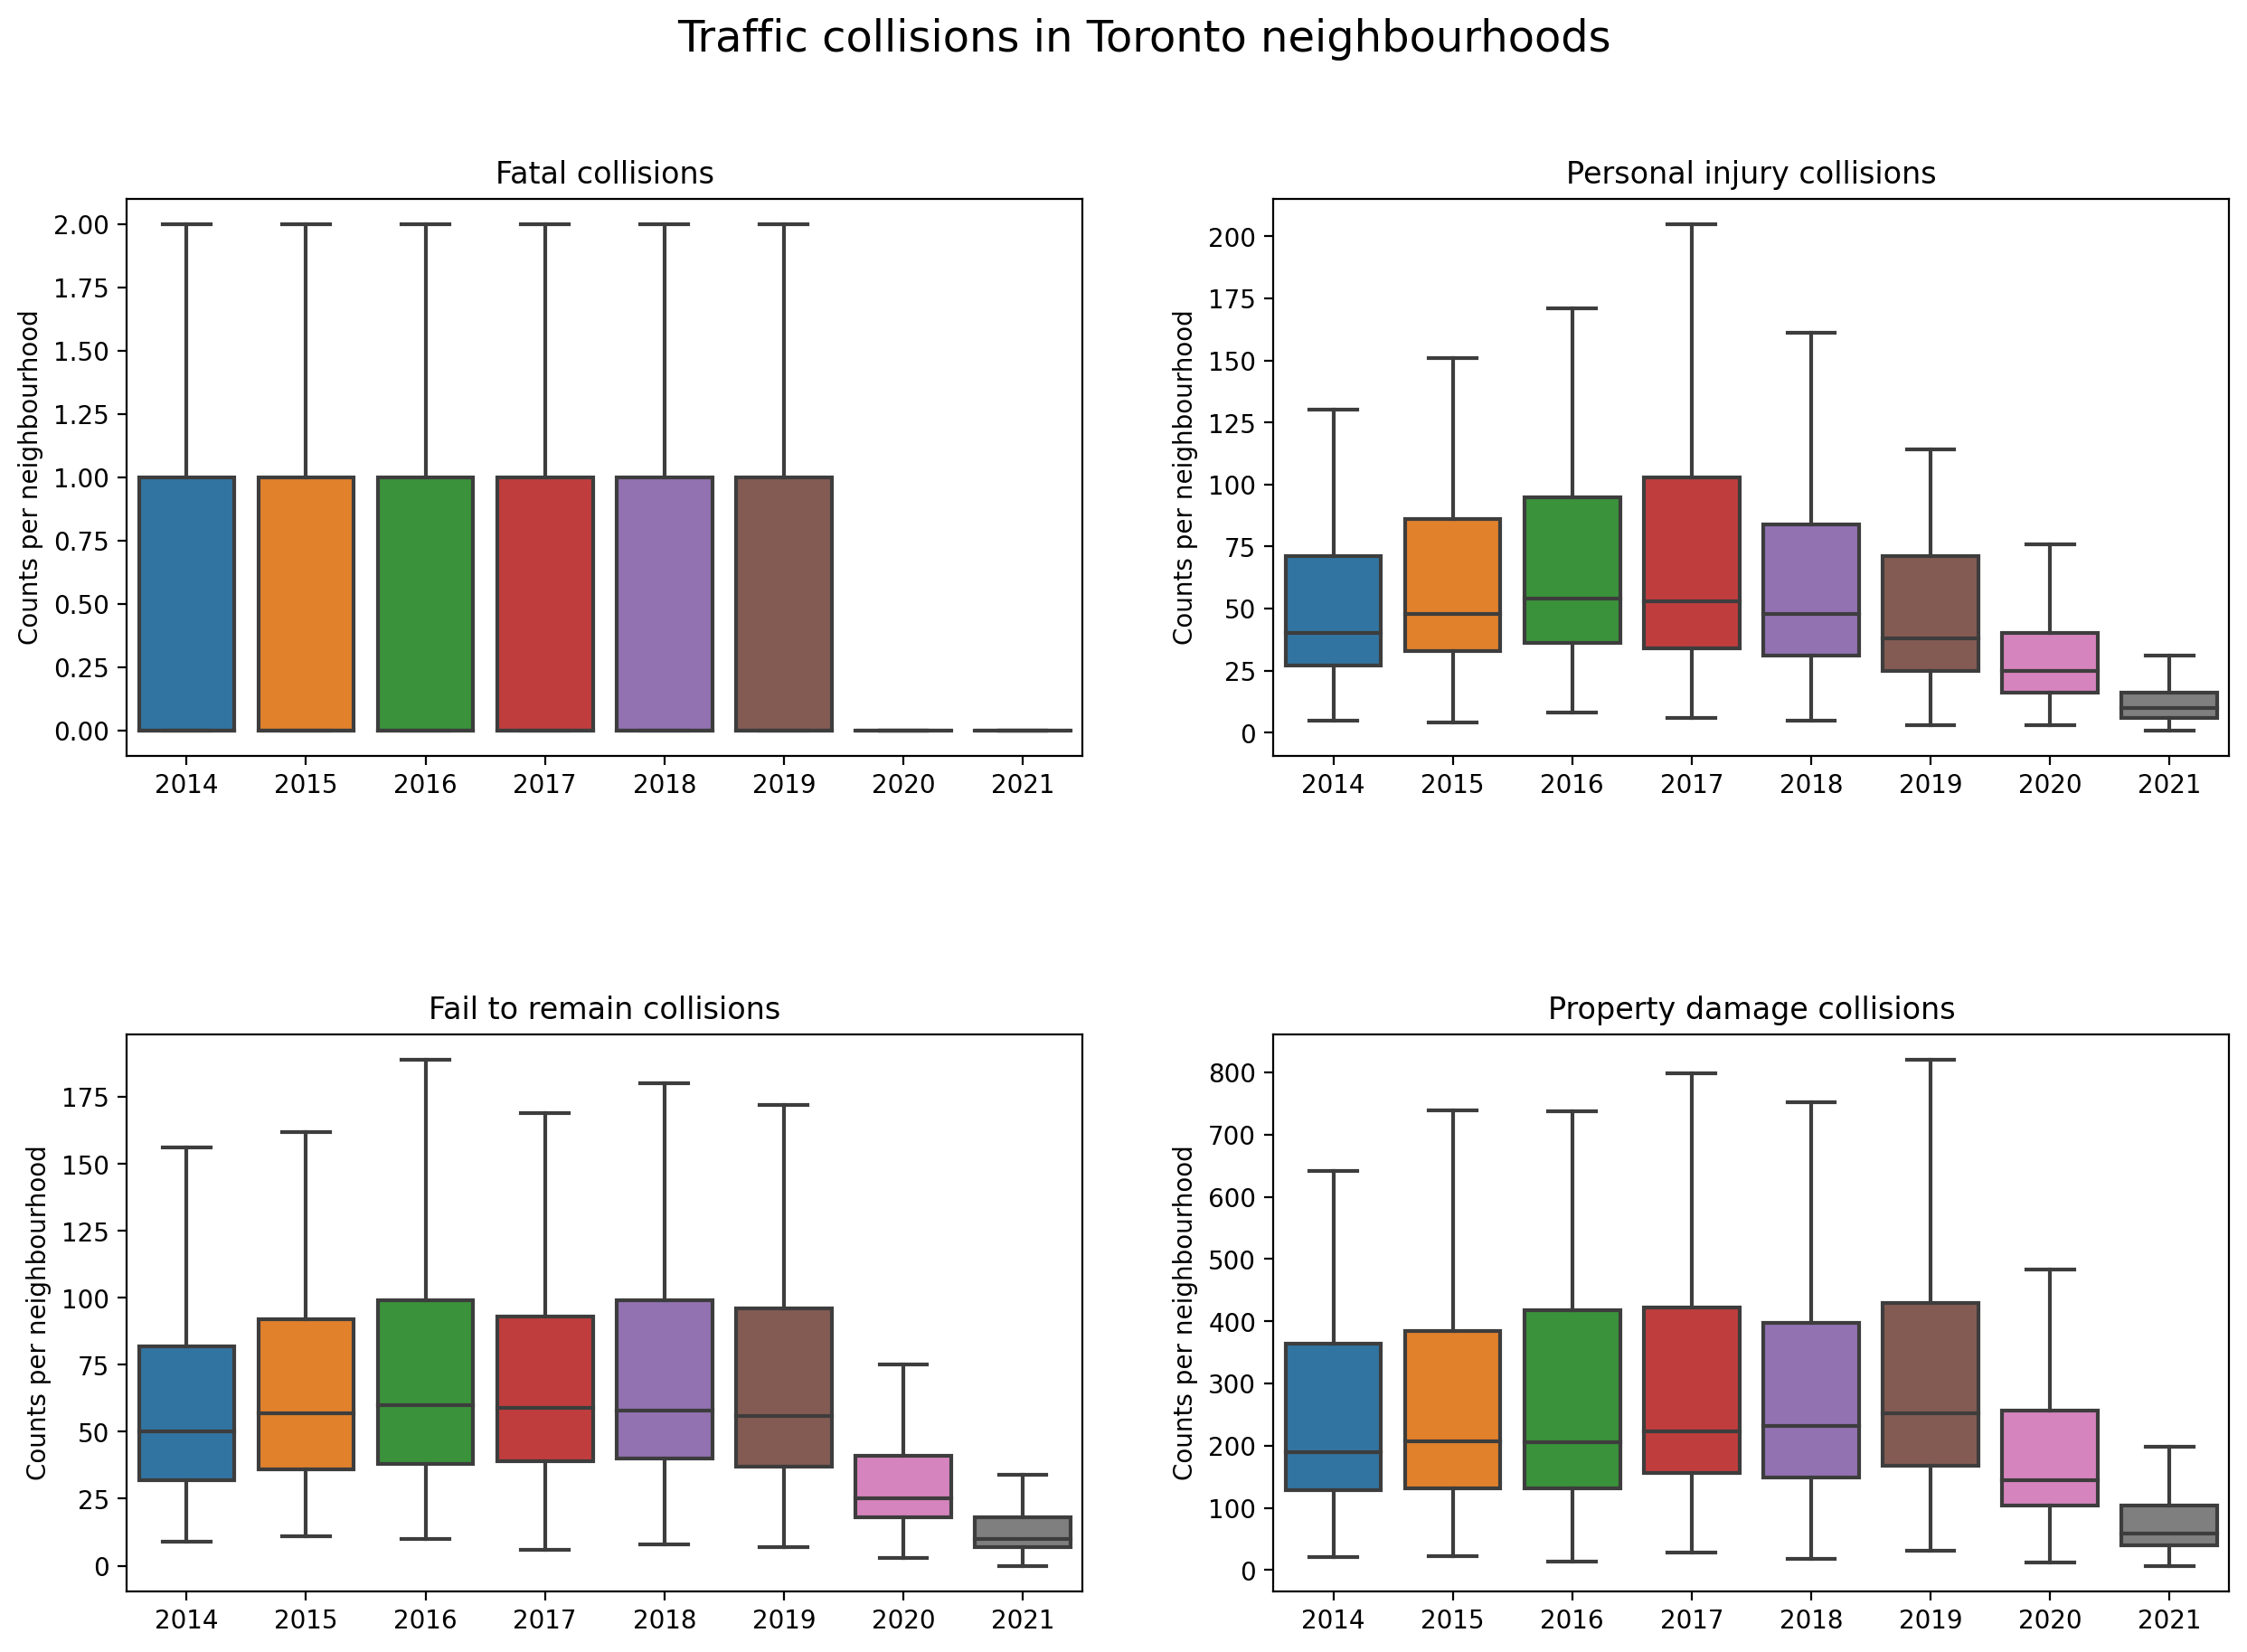

In [ ]:
vars = ['Fatal_Collisions', 'Injury_Collisions', 'FTR_Collisions', 'PD_Collisions']
titles = ['Fatal collisions',
          'Personal injury collisions', 
          'Fail to remain collisions', 
          'Property damage collisions']
fig, axes = plt.subplots(int(math.ceil(len(vars)/2)),2)
plt.subplots_adjust(hspace=0.5)
for var, title, ax in zip(vars, titles, axes.flatten()):    
    sns.boxplot(data = collision_point.groupby(['Neighbourhood', 'occurrenceyear']).agg({var: 'sum'}).reset_index(), 
                x = 'occurrenceyear',
                y = var,
                showfliers = False,
                ax = ax)
    ax.set_ylabel('Counts per neighbourhood')
    ax.set_xlabel('')
    ax.set_title(f"{title}")

fig.suptitle('Traffic collisions in Toronto neighbourhoods', size='xx-large')

## Neighbourhood collision rate and density

In [ ]:
neighbourhoods_collision = gpd.read_file('./clean_data/neighbourhoods_collision.geojson')
neighbourhoods_collision

,Neighbourhood,Hood_ID,district,distance_km,Collision_Count2014,Collision_Count2015,Collision_Count2016,Collision_Count2017,Collision_Count2018,Collision_Count2019,Collision_Count2020,Collision_Count2021,Collision_Density2014,Collision_Density2015,Collision_Density2016,Collision_Density2017,Collision_Density2018,Collision_Density2019,Collision_Density2020,Collision_Density2021,Collision_Rate2014,Collision_Rate2015,Collision_Rate2016,Collision_Rate2017,Collision_Rate2018,Collision_Rate2019,Collision_Rate2020,Collision_Rate2021,FatalCollisions_Count2014,FatalCollisions_Count2015,FatalCollisions_Count2016,FatalCollisions_Count2017,FatalCollisions_Count2018,FatalCollisions_Count2019,FatalCollisions_Count2020,FatalCollisions_Count2021,FatalCollisions_Density2014,FatalCollisions_Density2015,FatalCollisions_Density2016,FatalCollisions_Density2017,FatalCollisions_Density2018,FatalCollisions_Density2019,FatalCollisions_Density2020,FatalCollisions_Density2021,FatalCollisions_Rate2014,FatalCollisions_Rate2015,FatalCollisions_Rate2016,FatalCollisions_Rate2017,FatalCollisions_Rate2018,FatalCollisions_Rate2019,FatalCollisions_Rate2020,FatalCollisions_Rate2021,FtrCollisions_Count2014,FtrCollisions_Count2015,FtrCollisions_Count2016,FtrCollisions_Count2017,FtrCollisions_Count2018,FtrCollisions_Count2019,FtrCollisions_Count2020,FtrCollisions_Count2021,FtrCollisions_Density2014,FtrCollisions_Density2015,FtrCollisions_Density2016,FtrCollisions_Density2017,FtrCollisions_Density2018,FtrCollisions_Density2019,FtrCollisions_Density2020,FtrCollisions_Density2021,FtrCollisions_Rate2014,FtrCollisions_Rate2015,FtrCollisions_Rate2016,FtrCollisions_Rate2017,FtrCollisions_Rate2018,FtrCollisions_Rate2019,FtrCollisions_Rate2020,FtrCollisions_Rate2021,InjuryCollisions_Count2014,InjuryCollisions_Count2015,InjuryCollisions_Count2016,InjuryCollisions_Count2017,InjuryCollisions_Count2018,InjuryCollisions_Count2019,InjuryCollisions_Count2020,InjuryCollisions_Count2021,InjuryCollisions_Density2014,InjuryCollisions_Density2015,InjuryCollisions_Density2016,InjuryCollisions_Density2017,InjuryCollisions_Density2018,InjuryCollisions_Density2019,InjuryCollisions_Density2020,InjuryCollisions_Density2021,InjuryCollisions_Rate2014,InjuryCollisions_Rate2015,InjuryCollisions_Rate2016,InjuryCollisions_Rate2017,InjuryCollisions_Rate2018,InjuryCollisions_Rate2019,InjuryCollisions_Rate2020,InjuryCollisions_Rate2021,PdCollisions_Count2014,PdCollisions_Count2015,PdCollisions_Count2016,PdCollisions_Count2017,PdCollisions_Count2018,PdCollisions_Count2019,PdCollisions_Count2020,PdCollisions_Count2021,PdCollisions_Density2014,PdCollisions_Density2015,PdCollisions_Density2016,PdCollisions_Density2017,PdCollisions_Density2018,PdCollisions_Density2019,PdCollisions_Density2020,PdCollisions_Density2021,PdCollisions_Rate2014,PdCollisions_Rate2015,PdCollisions_Rate2016,PdCollisions_Rate2017,PdCollisions_Rate2018,PdCollisions_Rate2019,PdCollisions_Rate2020,PdCollisions_Rate2021,geometry
0,Yonge-St.Clair,97,C02,2.791462,238.0,275.0,288.0,305.0,301.0,315.0,191.0,68.0,204.939633,236.799996,247.994178,262.632723,259.188359,271.243632,164.468361,58.554181,1889.338731,2157.539620,2223.938224,2308.158014,2228.309150,2284.429618,1356.341429,472.838689,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.861091,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.938398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.0,44.0,55.0,60.0,53.0,51.0,18.0,8.0,27.554909,37.887999,47.359999,51.665454,45.637817,43.915636,15.499636,6.888727,254.028737,345.206339,424.710425,454.063872,392.360083,369.860033,127.822752,55.628081,21.0,31.0,34.0,33.0,18.0,22.0,13.0,6.0,18.082909,26.693818,29.277090,28.416000,15.499636,18.944000,11.194182,5.166545,166.706359,243.213557,262.548263,249.735129,133.254368,159.547465,92.316432,41.721061,184.0,203.0,205.0,220.0,232.0,252.0,166.0,58.0,158.440725,174.801452,176.523633,189.439997,199.773088,216.994906,142.941089,49.943272,1460.665238,1592.656520,1583.011583,1664.90086

In [ ]:
collision_type = sorted(list(set([re.search('(\w+)_Rate', x).group(1) for x in neighbourhoods_collision.columns if re.search('(\w+)_Rate', x) is not None])))
collision_type

['Collision',
 'FatalCollisions',
 'FtrCollisions',
 'InjuryCollisions',
 'PdCollisions']

In [ ]:
# set custom order for display
custom_collision_order = ['Collision','FatalCollisions', 'InjuryCollisions','FtrCollisions','PdCollisions']
collision_rate = [x + '_Rate' for x in custom_collision_order]
collision_density = [x + '_Density' for x in custom_collision_order]
collision_years = sorted(list(set([re.search('\d+', x).group(0) for x in neighbourhoods_collision.columns if re.search('\d+', x) is not None])))

In [ ]:
def plot_collision(var, title):
    fig, axes = plt.subplots(len(collision_years), len(var))

    for j in range(axes.shape[1]):
        # fix the range for each type of collision so we can compare across years
        vmin, vmax = neighbourhoods_collision[[var[j] + str(year) for year in collision_years]].min().min(), neighbourhoods_collision[[var[j] + str(year) for year in collision_years]].max().max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)
        for i in range(axes.shape[0]):  
            neighbourhoods_collision.plot(column = var[j] + str(collision_years[i]), 
                                cmap = 'viridis',
                                norm = norm,
                                ax = axes[i, j])
        
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(var[j].split("_")[0])
            if j == 0:
                axes[i,j].set_ylabel(collision_years[i], rotation=90, size='large')

    fig.suptitle(title, size='xx-large')

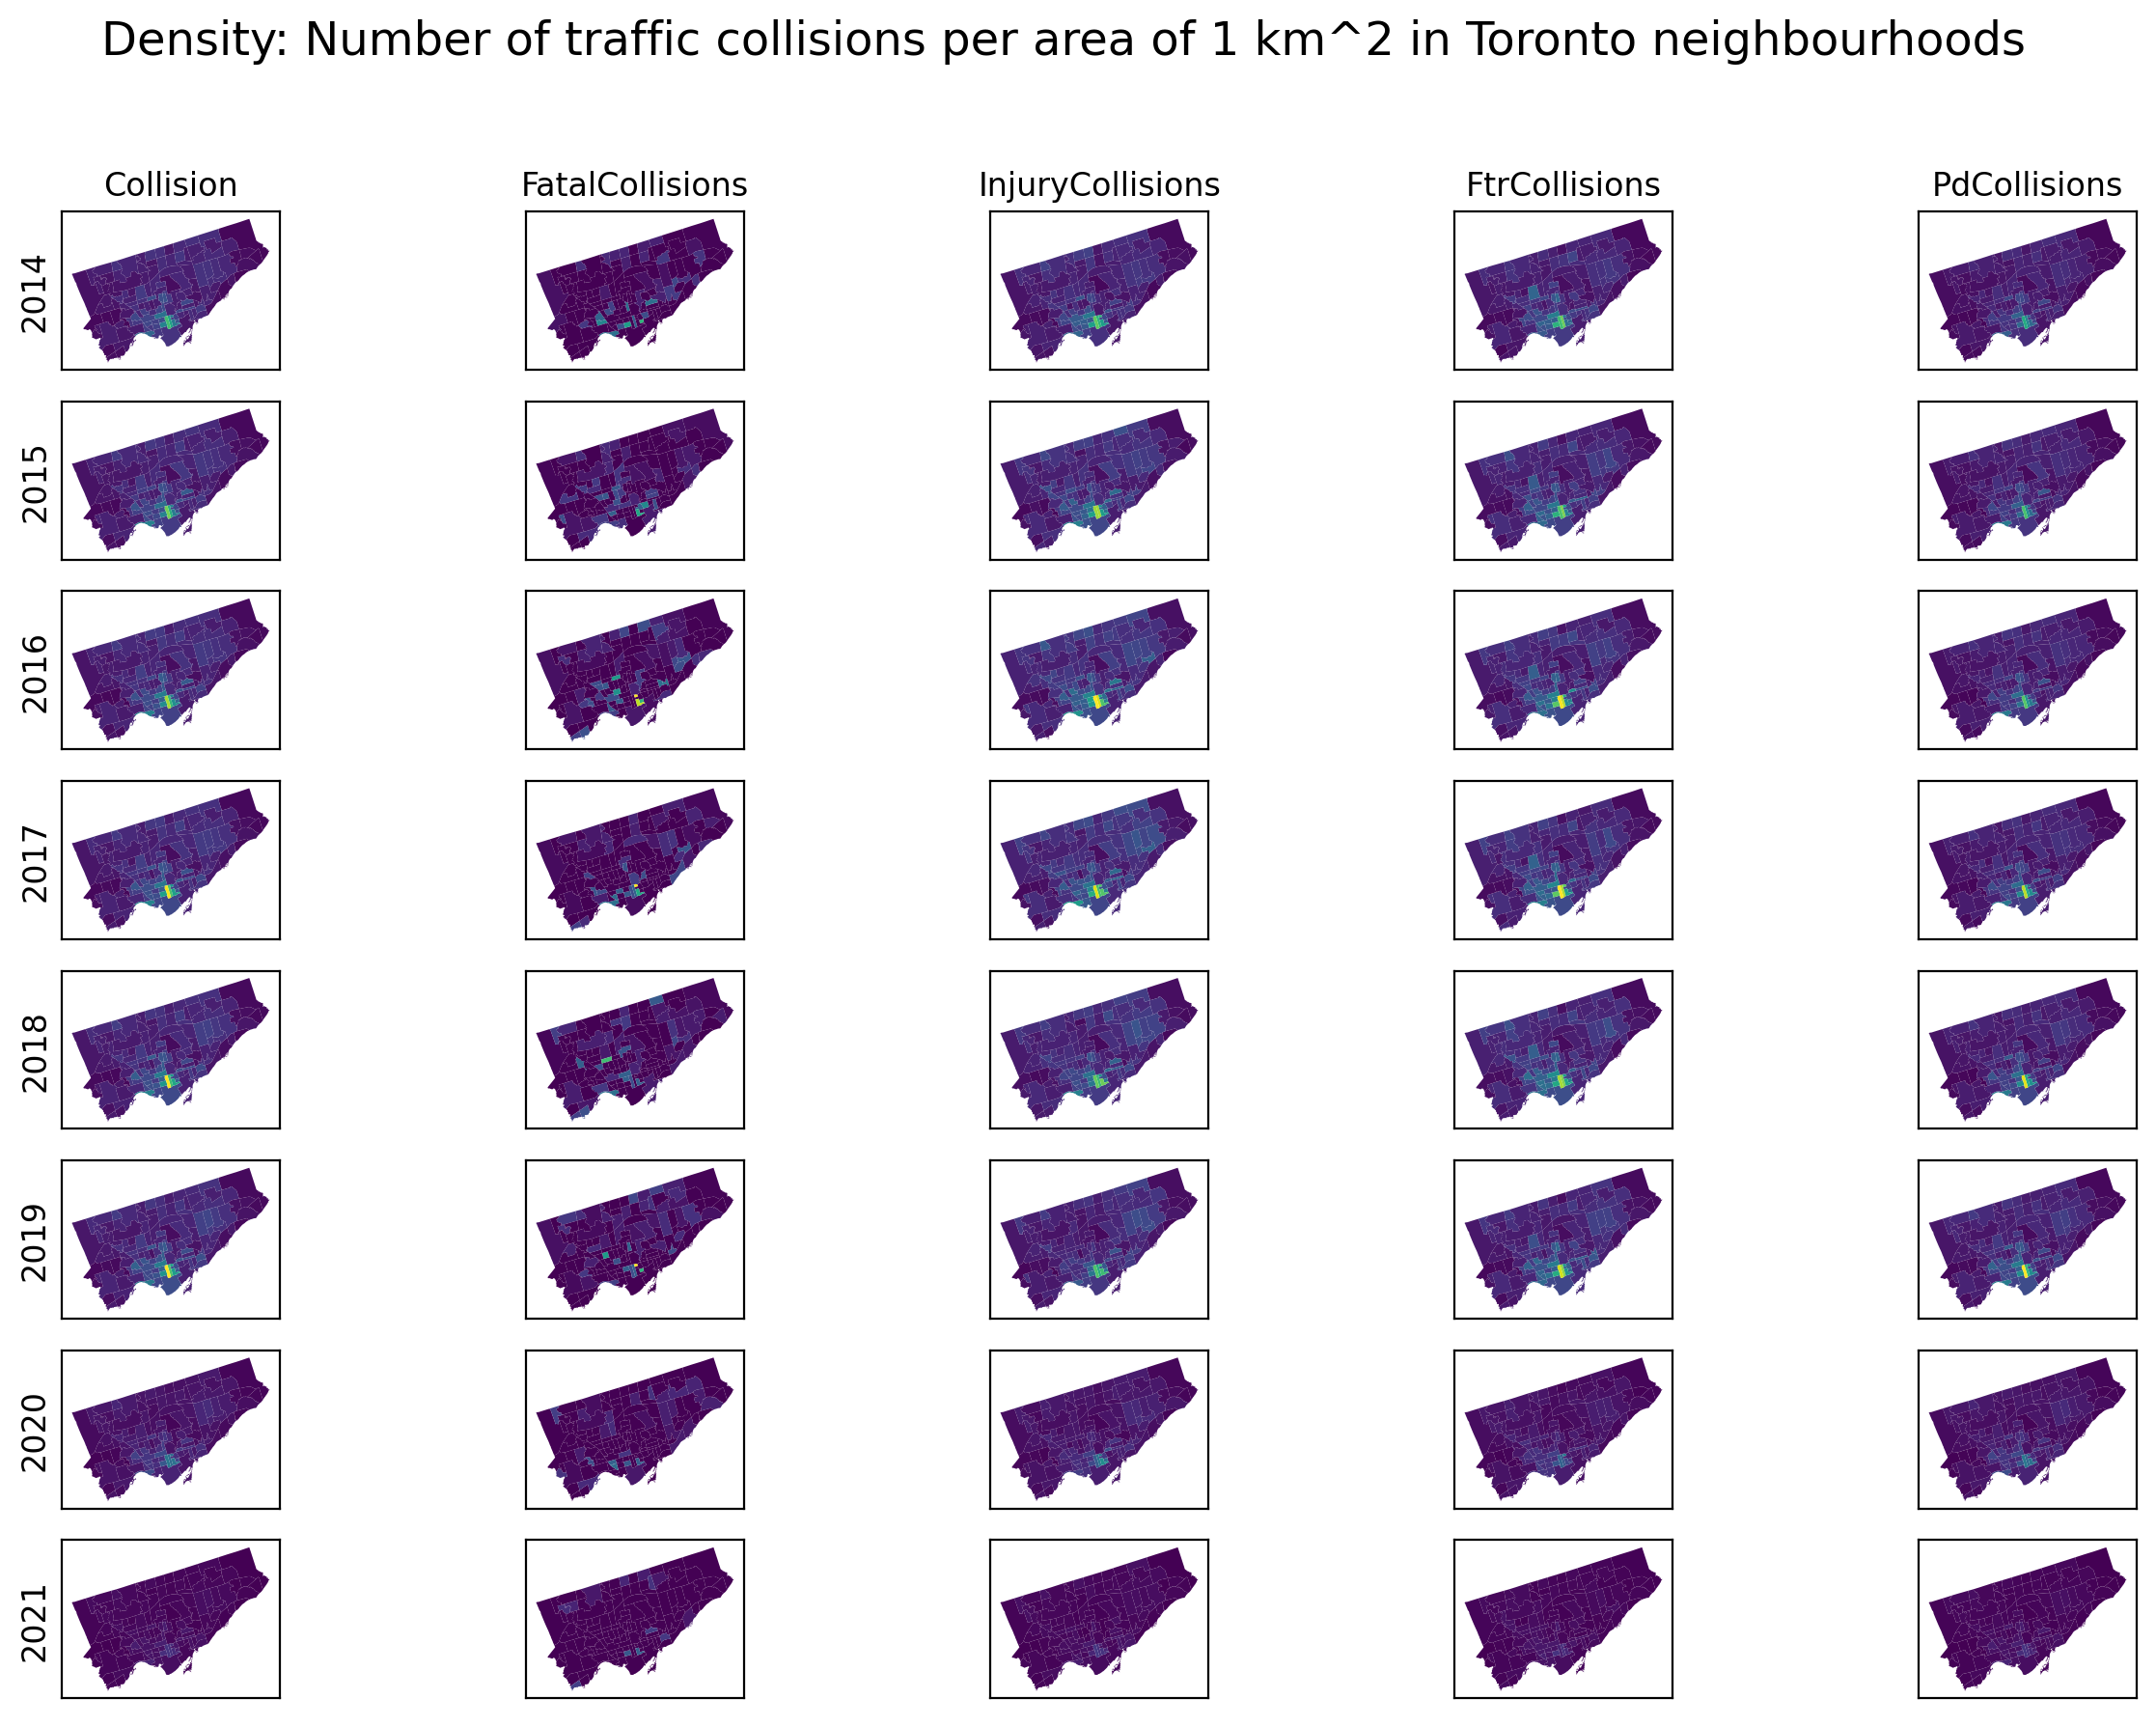

In [ ]:
plot_collision(collision_density, 'Density: Number of traffic collisions per area of 1 km^2 in Toronto neighbourhoods')

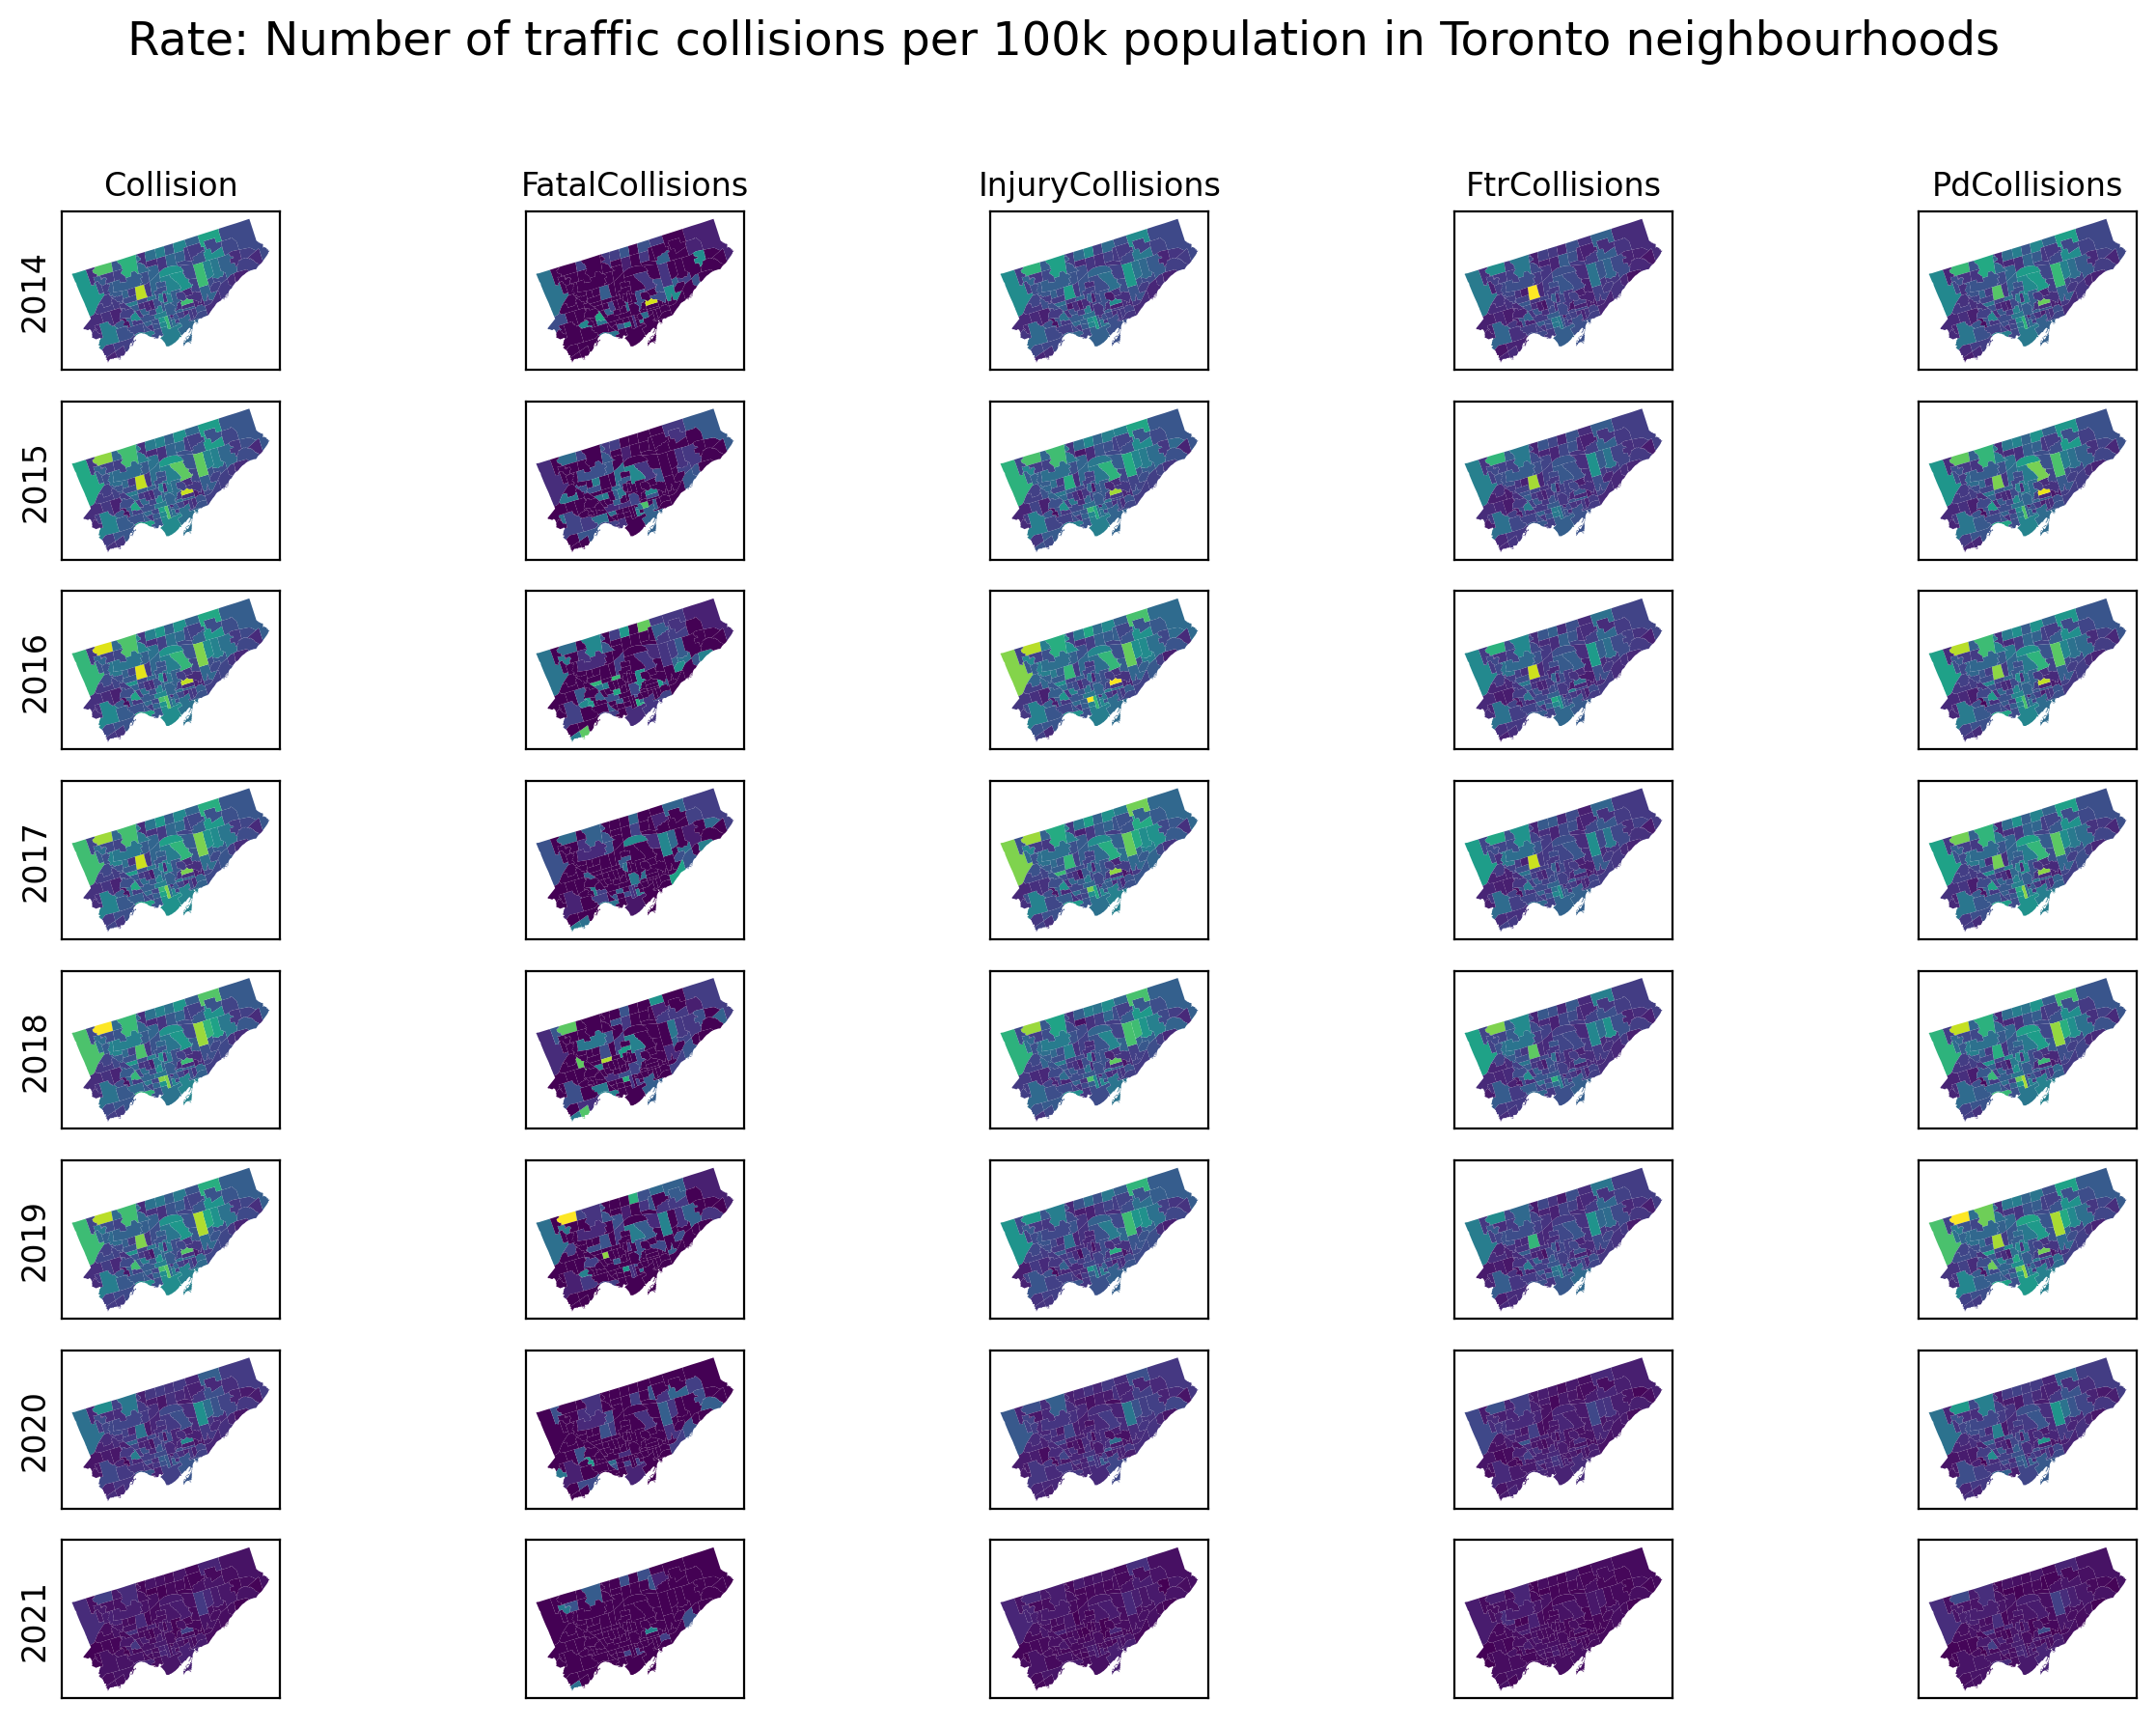

In [ ]:
plot_collision(collision_rate, 'Rate: Number of traffic collisions per 100k population in Toronto neighbourhoods')

In [ ]:
# plotly version
# crime_allrate = pd.wide_to_long(neighbourhoods_crime[['Neighbourhood', 'Hood_ID', 'geometry'] + ['All_Rate' + str(year) for year in crime_years]],]], 
#                                   stubnames= "All_Rate", 
#                                   i=['Neighbourhood', 'Hood_ID'], 
#                                   j='year',
#                                   sep='').reset_index()

# crime_allrate.head()

# fig = px.choropleth(crime_allrate, 
#               geojson=crime_allrate.geometry,
#               locations=crime_allrate.index,
#               color = 'All_Rate',
#               animation_frame='year',
#               color_continuous_scale="Viridis",
#               hover_data=['Neighbourhood'])
# fig.update_geos(fitbounds="locations", visible=False)

Text(0.5, 257.52801096780723, 'Longitude')

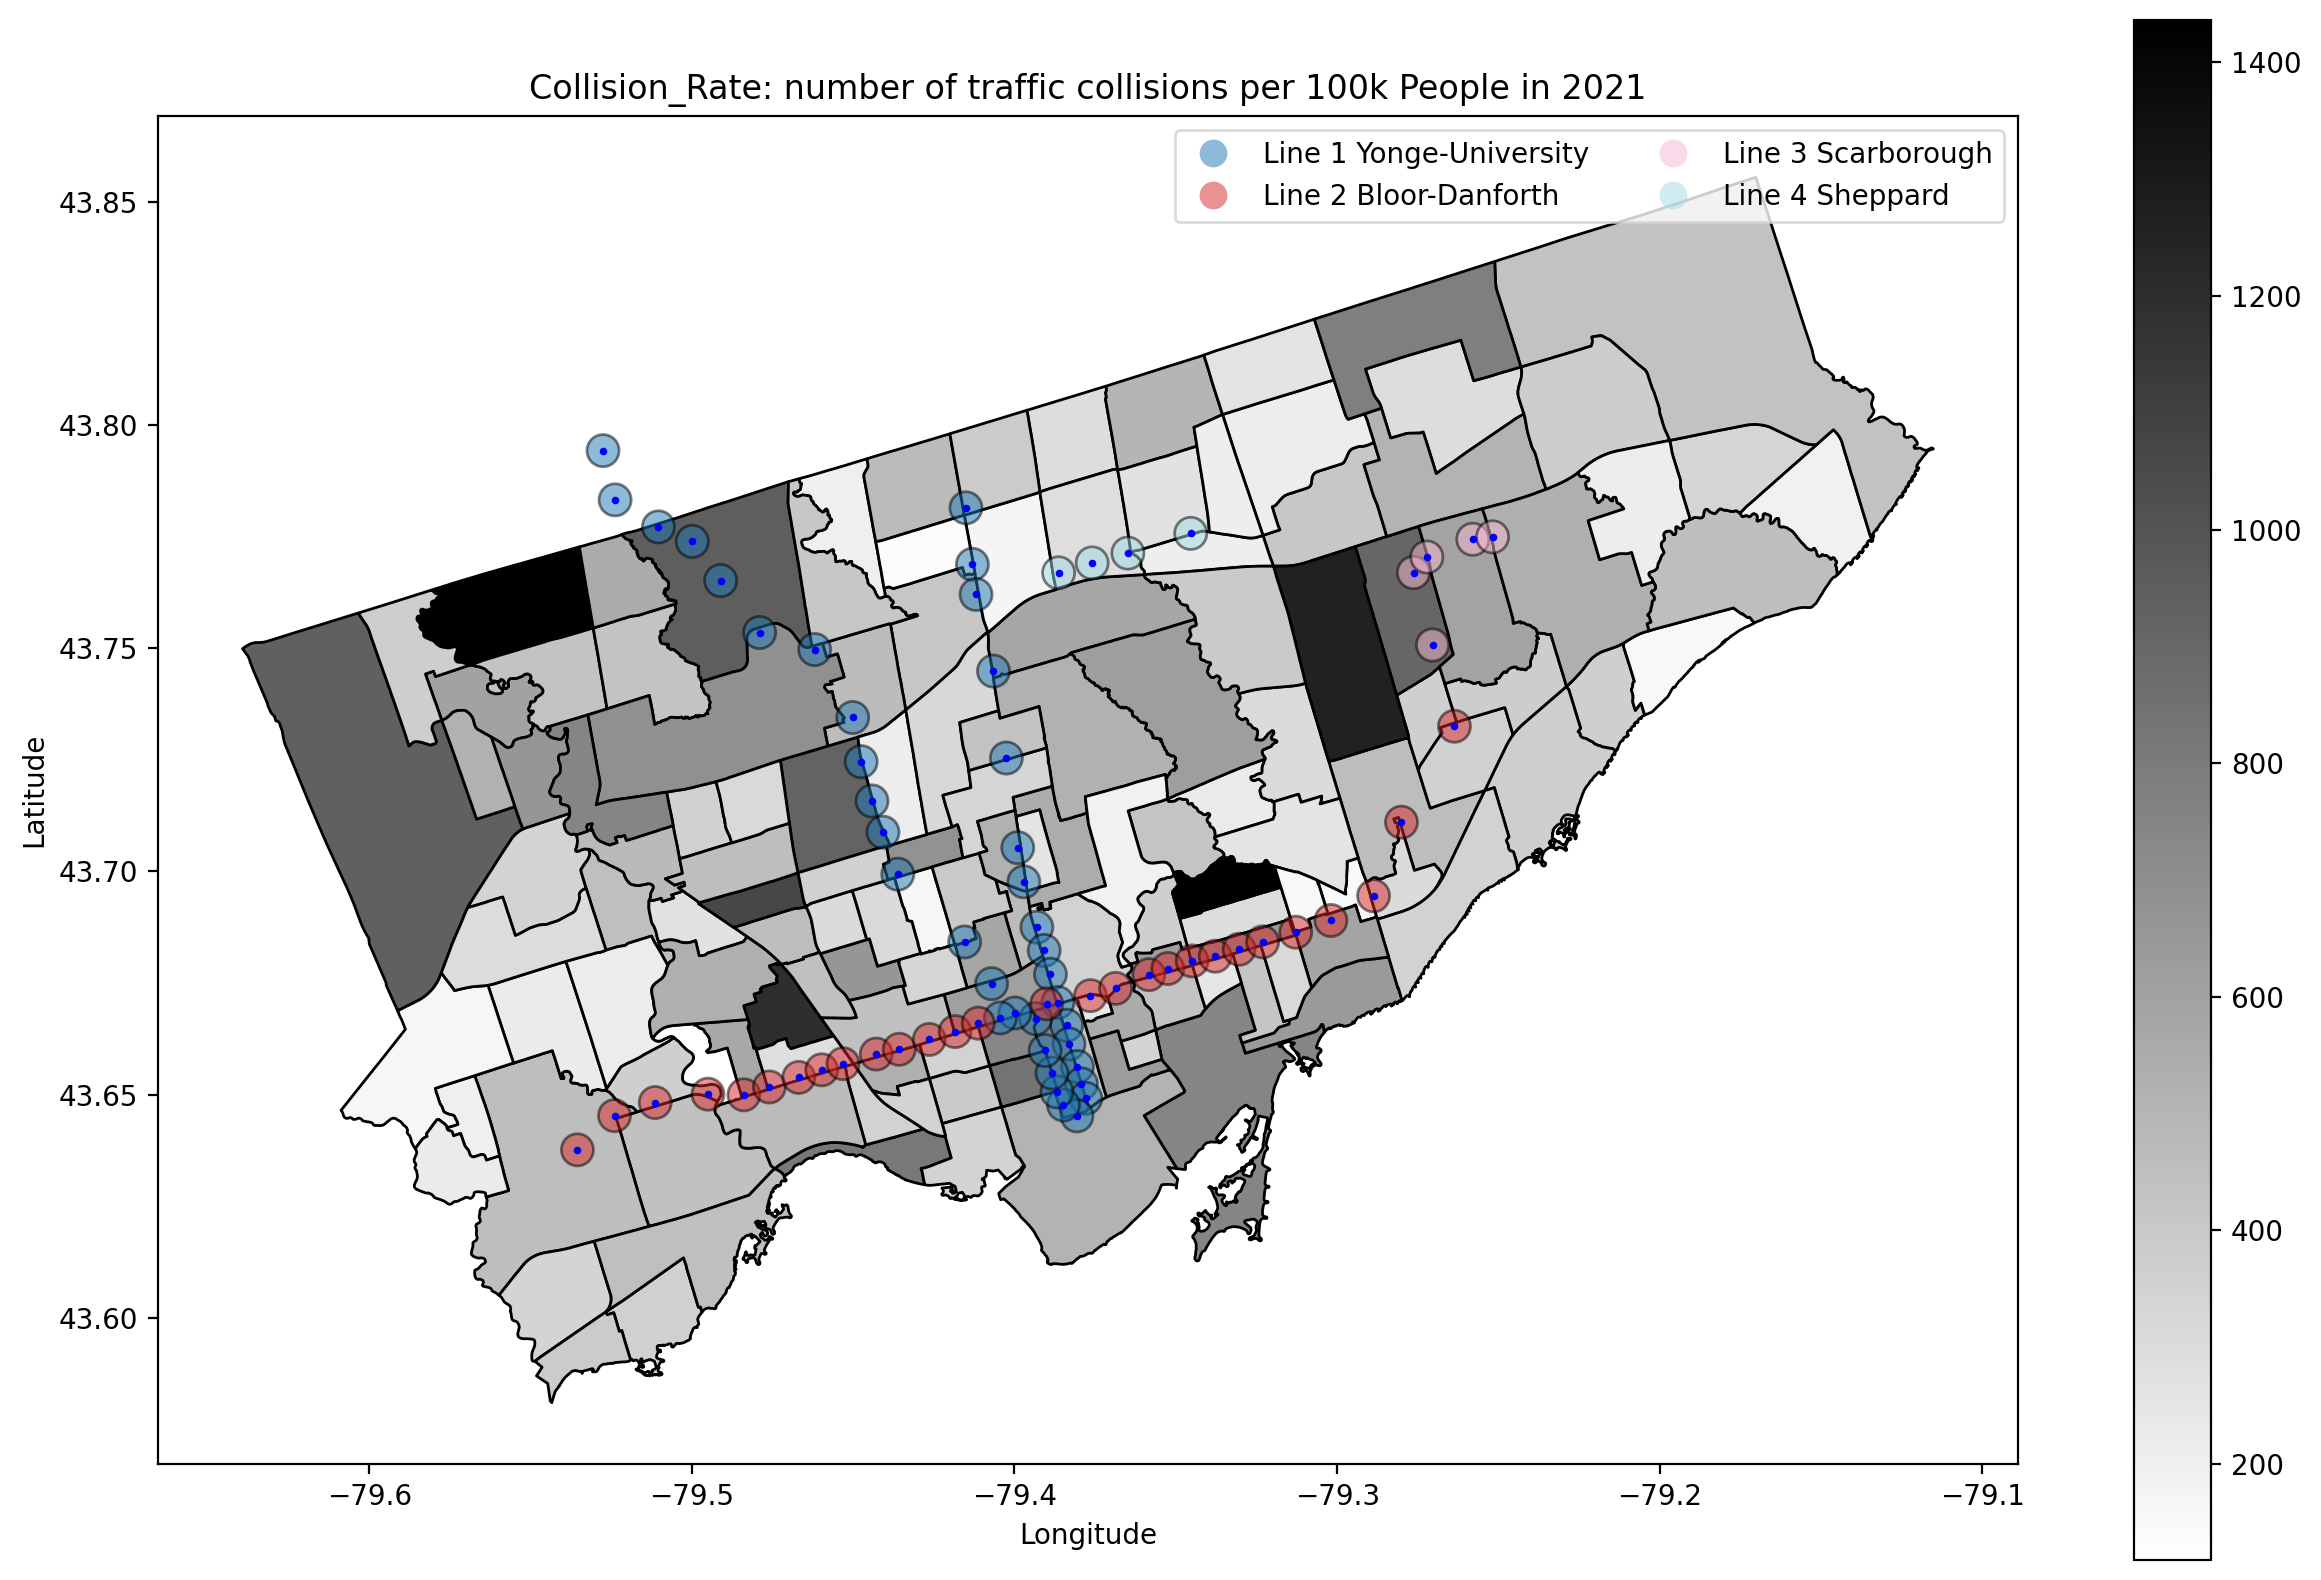

In [ ]:
var = "Collision_Rate"
year = 2021
ax = neighbourhoods_collision.plot(column = var + str(year), 
                               edgecolor = 'black',
                               cmap = 'bwr',
                               # norm = norm,
                               legend = True)

stations_area.plot(column = 'line', 
                edgecolor = 'black', 
                alpha = 0.5,
                cmap = 'tab20',
                legend = True,
                legend_kwds = {'loc': 'upper right', 
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                ax = ax)
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

ax.set_title(var + ": number of traffic collisions per 100k People in " + str(year))
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

In [ ]:
alphas = {'distance': 0.1, 
          'rental': 0.3, 
          'safety': 0.3, 
          'safety_homicide': 0.05,
          'safety_shootings': 0.05,
          'traffic': 0.2}

for key, value in alphas.items():
    alphas[key] = value * 3

for key, value in alphas.items():
    print(key, value)

distance 0.30000000000000004
rental 0.8999999999999999
safety 0.8999999999999999
safety_homicide 0.15000000000000002
safety_shootings 0.15000000000000002
traffic 0.6000000000000001
